# Image Classification


*Christina Brockway*

**Create a Tensorflor Image Dataset**
-  
Create a Dataset using the tf.keras.image_dataset_from_directory function.    -  
You are free to select your own image size and batch size, but be careful not to do a very large image size and batch size that causes your computer to crash/run poorly-  .
Save the class_names and number of classes as variables to reuse late-  r.
Create a class_dict that has integers as the keys with the corresponding class names (sorted alphabetical-  ly)
Split the dataset into a training-validation-test sp    -  lit.
Tip: You may adjust the sizes of the splits, but we recommend 70% training/20% validation/10% test as a starting p    -  oint.
Hint: use .take() and .skip()

**Optimize the Dataset**
-  
Add a shuffle step to the training dataset.-  
Add caching and prefetching to all 3 dataset    -  s
Note: If your computer doesn't have sufficient storage space and you experience hardware issues using caching, you may skip this requiremen    -  t.
Note: If your computer has a low amount of memory (RAM and you experience hardware issues, you may skip/exclude prefetching.

**Preview the Data and Save the Shape**
-  
Retrieve a batch of training data and save the first image's shape to use in your model's input_shape.-  
Display an example image-  .
Display an example label.

#### Modeling
**Modeling Steps (for every model)**
-  For every model:
    -  Fitting the Model:
        -  using validation_data
        -  many epochs (20+)
        -  an EarlyStopping callback.
        -  Save the training history
-  Evaluating the Model:
    -  Plot the training history
    -  Evaluate the model on the training and test data, including:
        -  Scikit-learn confusion matrix
        -  Scikit-learn classification report
        -  The results from model.evaluate method.
        -  (Tip: Use your custom flexible evaluation functions.)

#### Modeling Requirements
**
1) Build a Simple CNN Mode**l    -  

Start with a simple/baseline Convolutional Neural Network as a baseline model. Fit and evaluate the model according to the modeling steps abov        -  e.
Remember: This is your baseline model that you will continue to improve upon in the following models. So don't worry too much about getting a high accura        -  cy.
Tip: You may use the same baseline model from the "TensorFlow Dataset Objects" le
        s**son.
2) Build a more complex CN** m-  odel

Fit and evaluate a more complex model according to the modeling steps -  above.

Some suggested things        -   to try:

Consider adding hidden De        -  nse layers.
Consider usin        -  g KerasTuner
Consider adding more convolutional/po            -  oling layers.
Try using 2 x Conv2D layers back-to-back before the             -  pooling layer.
Try changing the number of filters in each layer (the same # of filters, or increasing # of        -   filters, etc.)
Consider applying D
   a**ta Augmentation.
3) Build a Transfer Learning Modeling Using a** K-  eras Application

For the last model, apply transfer learning for     -  feature extraction.
Download the base only    -   (include_top=False)
Create the correct Lambda preprocessing     -  layer for that model.
Make sure to set trainable=False. If you do not do this, the pre-trained models become very resource-intensive to the point where your computer may crash.

#### Choose Your Best Model-  
Decide which model was the best that you would put into production.-  
Save the model as a .keras file using model.save()

## load Data, Imports, and Functions

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob

import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import visualkeras as vk
tf.__version__

'2.12.0'

In [2]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()




### FINAL FROM FLEXIBILE EVAL FUNCTIONS LESSON

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")


    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


##########

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)

        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)

    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs


def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y has is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y has 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)


def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)

    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)


    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)

        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))

    # If no X_train, then save empty list for results_train
    else:
        results_train = []


    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)

        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')

        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))

    # If no X_test, then save empty list for results_test
    else:
        results_test = []


    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
# check contents of xrays folder
datadir = "data/xray"
datadir

'data/xray'

In [4]:
# Get list of img file paths
imgfiles = glob.glob(datadir+"/**/*")
len(imgfiles)

6634

In [5]:
#preview image
imgloaded = load_img(imgfiles[0])
img_data = img_to_array(imgloaded)
img_data.shape

(864, 926, 3)

### Create a Tensoflow Image Dataset

In [6]:
#Save image parameters as variables 
batch_size=32
img_height=128
img_width=128

In [7]:
# make the dataset from the main folder
ds=tf.keras.utils.image_dataset_from_directory(
    datadir, shuffle=True, label_mode='categorical', seed=42,
    image_size=(img_height, img_width), batch_size=batch_size)
ds

Found 6617 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [8]:
# determine number of batches in dataset
dssize = len(ds)
dssize

207

In [9]:
# The original (non-take/non-skip) dataset contains the class_names
class_names  = ds.class_names
class_dict= dict(zip(range(len(class_names)), class_names))
class_dict

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [10]:
#saving num_class
num_class = len(class_names)
num_class

3

In [11]:
# Taking a sample batch to see batch shape
example_batch, example_batch_y=ds.take(1).get_single_element()
example_batch.shape

TensorShape([32, 128, 128, 3])

In [12]:
input_shape=example_batch[0].shape
input_shape

TensorShape([128, 128, 3])

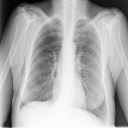

In [13]:
array_to_img(example_batch[0])

In [14]:
#Set the size of the split
split_train = 0.7
split_val = 0.2
split_test = 0.1

In [15]:
# calculate number of batches 
n_train_batches =  int(len(ds) * split_train)
n_val_batches = int(len(ds) * split_val)

print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data")

Use 144 batches as training data
Use 41 batches as validation data
The remaining 22 batches will be used as test data


In [16]:
# slice out the number of batches
train_ds = ds.take(n_train_batches)
#Confirm len of training set
len(train_ds)

144

In [17]:
#Skip training batches
val_ds = ds.skip(n_train_batches)
#take the corct number of validation batches
val_ds = val_ds.take(n_val_batches)
len(val_ds)

41

In [18]:
#skip over training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
len(test_ds)

22

### Optimize Dataset

In [19]:
# Use autotune to determinde best buffer sizes
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(buffer_size=len(train_ds),
                                    seed = 42).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Preview Data and Save Shape

In [20]:
# Get batch of training data and save the first img shape
batch_img, batch_labels = train_ds.take(1).get_single_element()
img = batch_img[0]
label=batch_labels[0]
input_shape = img.shape

covid


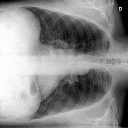

(128, 128, 3)


In [21]:
# Display example image and example label
label= class_dict[np.argmax(label)]
print(label)
display(array_to_img(img))
print(input_shape)

### Modeling

In [22]:
def build_model(name="Classifying X-rays", input_shape=input_shape):
    #Instantiate model
    model= models.Sequential(name=name)
   
    #Scaling layer
    scaling_layer = layers.Rescaling(1.0/255, input_shape=input_shape)
    model.add(scaling_layer)

    #Convolutional Layer
    model.add(layers.Conv2D(
        filters=16,kernel_size=3, input_shape=input_shape, padding='same'))

    #Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))

    #Convolutional Layer
    model.add(layers.Conv2D(
        filters=32,kernel_size=3, input_shape=input_shape, padding='same'))

    #Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))

    #Flattening Layer
    model.add(layers.Flatten())

    #Output Layer
    model.add(layers.Dense(3, activation='softmax'))

    #Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

#### Baseline Model

In [23]:
baseline= build_model(name='Baseline')

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0  

In [24]:
#Instantiate Early Stopping
early_stopping = EarlyStopping(patience = 5)

In [25]:
# fit the model
history = baseline.fit(train_ds, validation_data=val_ds, epochs=20, 
                       verbose=False, callbacks=[early_stopping])

In [26]:
baseline.save('Models/baseline')

INFO:tensorflow:Assets written to: Models/baseline\assets


INFO:tensorflow:Assets written to: Models/baseline\assets


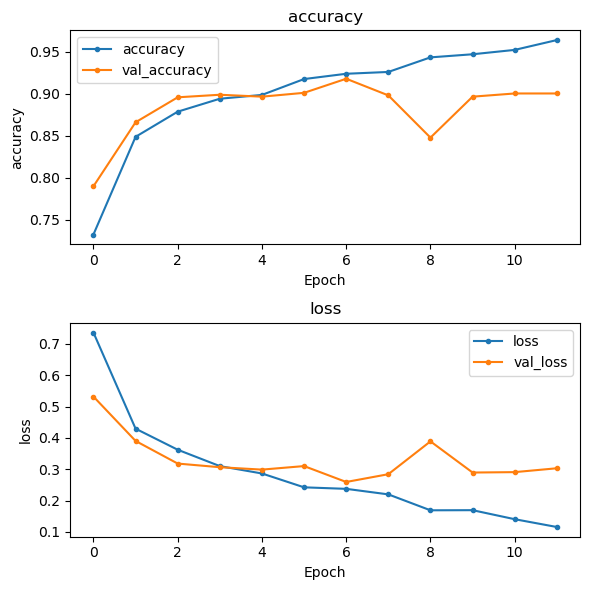


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1405
           1       0.98      0.96      0.97      1579
           2       0.98      0.97      0.97      1624

    accuracy                           0.98      4608
   macro avg       0.98      0.98      0.98      4608
weighted avg       0.98      0.98      0.98      4608



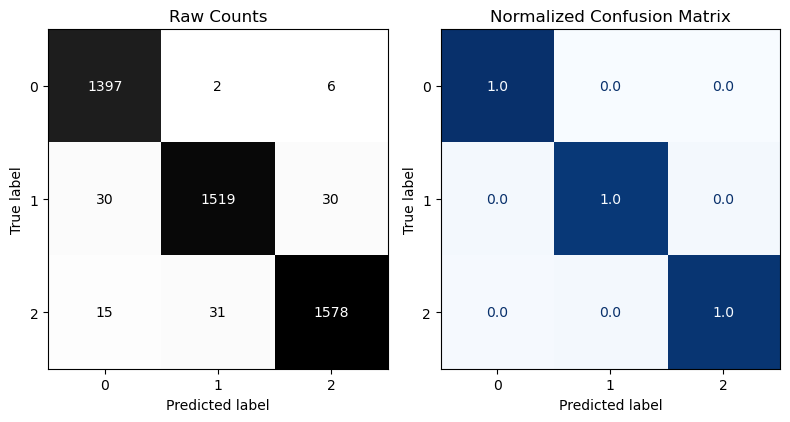


- Evaluating Training Data:
144/144 [==============================] - 9s 60ms/step - loss: 0.0897 - accuracy: 0.9753
{'loss': 0.08966860920190811, 'accuracy': 0.9752604365348816}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       194
           1       0.92      0.86      0.89       251
           2       0.90      0.93      0.91       252

    accuracy                           0.91       697
   macro avg       0.91      0.91      0.91       697
weighted avg       0.91      0.91      0.91       697



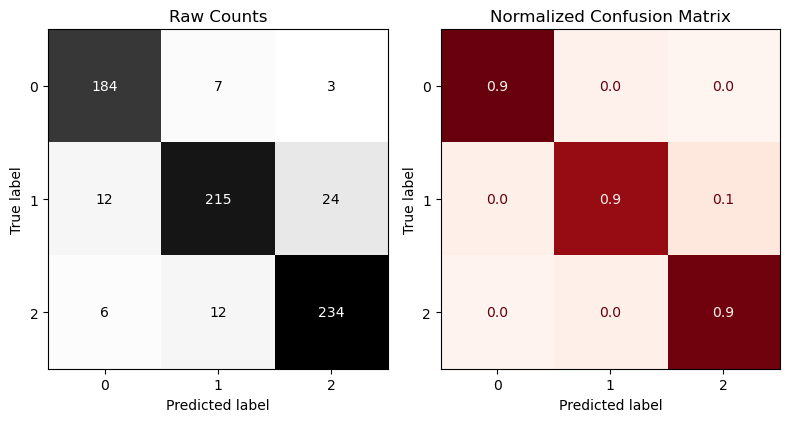


- Evaluating Test Data:
22/22 [==============================] - 1s 61ms/step - loss: 0.2796 - accuracy: 0.9082
{'loss': 0.2796107232570648, 'accuracy': 0.90817791223526}


In [27]:
# Use evaluation function
evaluate_classification_network(
    baseline, X_train=train_ds, X_test=test_ds,
    history=history, figsize=(8, 8), 
    values_format=".1f");

**Evaluation and Tuning**
- the baseline model has an accuracy rate of .88 and is calling some x-rays positive that aren't.
-  In order to reduce the false positives will add Data Augmentation
-  https://keras.io/api/layers/preprocessing_layers/image_augmentation/

#### Create Data Augmentation Pipeline/Model

In [28]:
# Create data augmentation 'model'
data_aug = models.Sequential([
    layers.RandomFlip('horizontal_and_vertical', input_shape=input_shape),
    layers.RandomRotation(0.15),
    layers.RandomZoom(height_factor=(-0.25,0.25),
                      width_factor=(-0.25,0.25)),])
data_aug

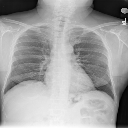

In [29]:
# Showing example image with keras 
image_index = 5
img = batch_img[image_index]
array_to_img(img)

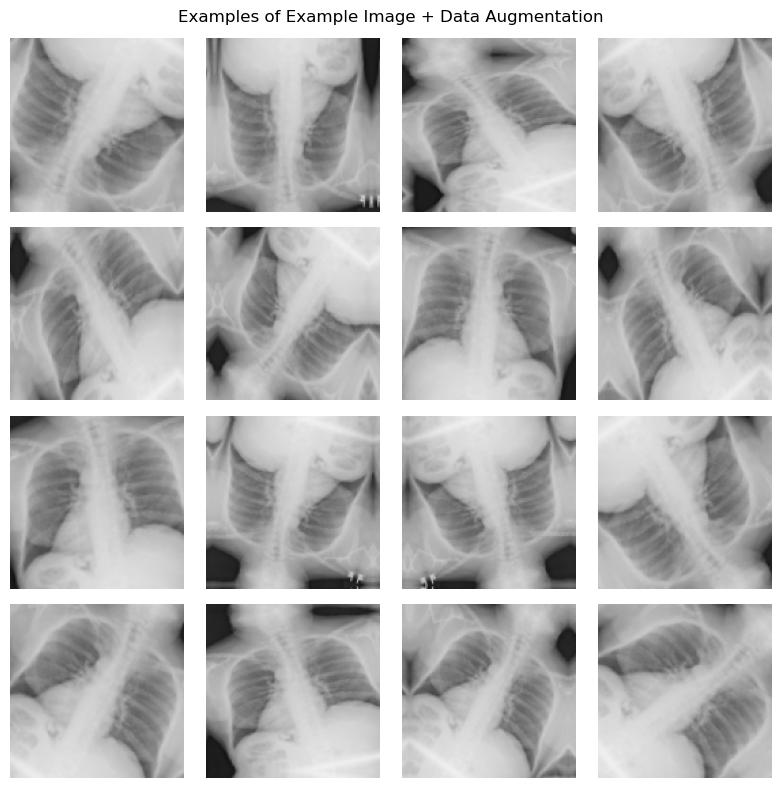

In [30]:
#Check if data aug works
#plot the same example augmented 16 times
fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)
axes = axes.flatten()
for images, _ in train_ds.take(1):
  for i,ax in enumerate(axes):
    ## Apply a round of data_augmentation and plot the same image 
    aug_images = data_aug(batch_img)
    ax.imshow(aug_images[image_index].numpy().astype(int))#, cmap='gray')
    ax.axis("off")
      
fig.suptitle('Examples of Example Image + Data Augmentation');
fig.tight_layout()

##### Add Augmentaion to Model

In [31]:
def build_aug_model(name="Classifying X-rays", input_shape=input_shape):
    #Instantiate model
    model= models.Sequential(name=name)
   
    #Scaling layer
    scaling_layer = layers.Rescaling(1.0/255, input_shape=input_shape)
    model.add(scaling_layer)

    #Create data augmentaion
    data_aug = models.Sequential([
        layers.RandomFlip('horizontal_and_vertical', input_shape=input_shape),
        layers.RandomRotation(0.15),
        layers.RandomZoom(height_factor=(-0.25,0.25),
                      width_factor=(-0.25,0.25),)], name='augmentation')
    model.add(data_aug)

    #Convolutional Layer
    model.add(layers.Conv2D(
        filters=32,kernel_size=3, input_shape=input_shape, padding='same'))

    #Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))

    #Convolutional Layer
    model.add(layers.Conv2D(
        filters=32,kernel_size=3, input_shape=input_shape, padding='same'))

    #Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))

    #Flattening Layer
    model.add(layers.Flatten())

    #Output Layer
    model.add(layers.Dense(3, activation='softmax'))

    #Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

##### Data Augmentation Model

In [32]:
damodel= build_model(name='DAModel')

Model: "DAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0   

In [33]:
# fit the model
dahistory = damodel.fit(train_ds, validation_data=val_ds, epochs=20, 
                       verbose=False, callbacks=[early_stopping])

In [34]:
#save the model
damodel.save('Models/data_aug_model')

INFO:tensorflow:Assets written to: Models/data_aug_model\assets


INFO:tensorflow:Assets written to: Models/data_aug_model\assets


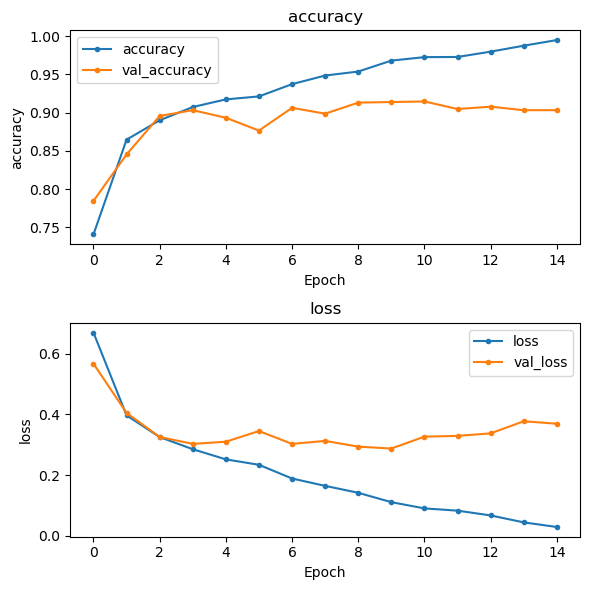


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1405
           1       1.00      1.00      1.00      1579
           2       1.00      1.00      1.00      1624

    accuracy                           1.00      4608
   macro avg       1.00      1.00      1.00      4608
weighted avg       1.00      1.00      1.00      4608



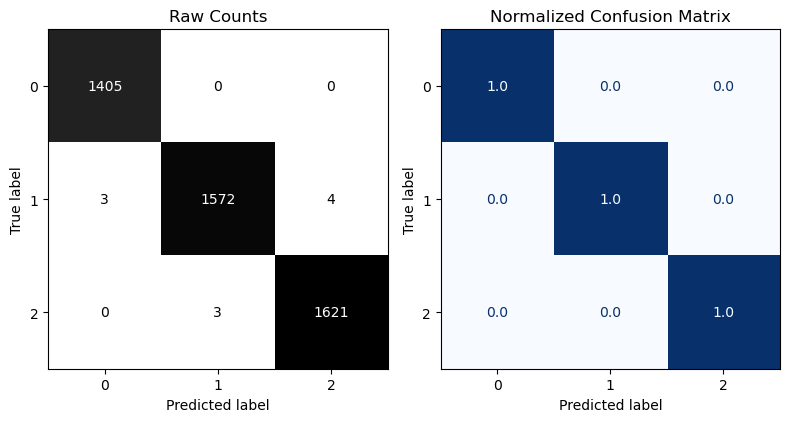


- Evaluating Training Data:
144/144 [==============================] - 9s 61ms/step - loss: 0.0185 - accuracy: 0.9978
{'loss': 0.018478596583008766, 'accuracy': 0.9978298544883728}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       194
           1       0.87      0.86      0.87       251
           2       0.89      0.92      0.91       252

    accuracy                           0.89       697
   macro avg       0.90      0.89      0.89       697
weighted avg       0.89      0.89      0.89       697



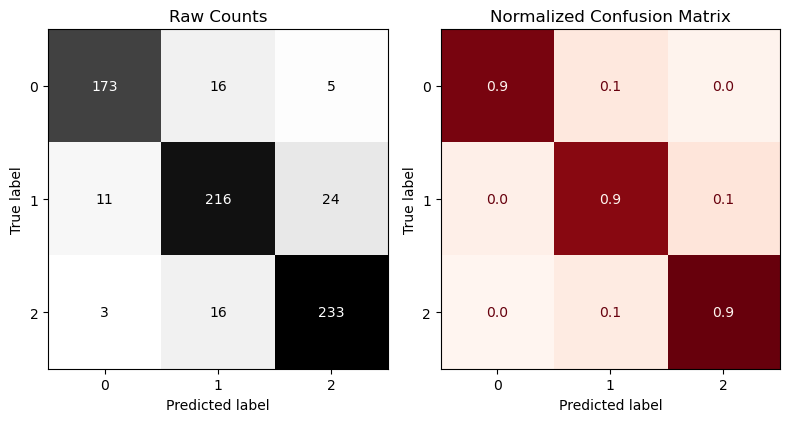


- Evaluating Test Data:
22/22 [==============================] - 1s 61ms/step - loss: 0.3872 - accuracy: 0.8924
{'loss': 0.3871971070766449, 'accuracy': 0.8923959732055664}


In [35]:
# Use evaluation function
evaluate_classification_network(
    damodel, X_train=train_ds, X_test=test_ds,
    history=dahistory, figsize=(8, 8), 
    values_format=".1f");

**Evaluate Data Augmentation Model**
-  Data Augmentaion has improved the models ability to classify normal x-rays.
  

#### Build a Transfer learning Model Using Keras Application

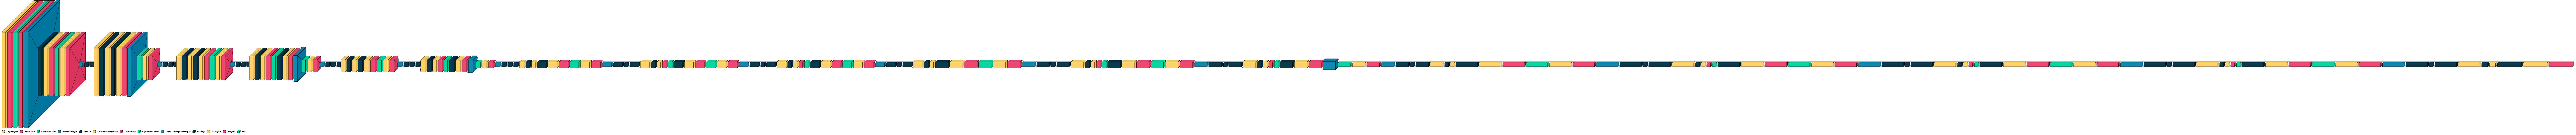

In [36]:
# download base model
efficientnet_base= tf.keras.applications.EfficientNetB0(
    include_top=False, input_shape=input_shape)

#make it not trainable
efficientnet_base.trainable=False
vk.layered_view(efficientnet_base, legend=True)

In [37]:
# add preprocessing lambda layer
lambda_layer=tf.keras.layers.Lambda(
    tf.keras.applications.efficientnet.preprocess_input, 
    name='preprocess_input')

def build_enet_model():
    model=models.Sequential(name="EfficientNetB0")

    #input layer
    model.add(tf.keras.layers.Input(shape=input_shape))

    #preprocessing layer
    model.add(lambda_layer)

    #Pretrained base
    model.add(efficientnet_base)

    #Flattening Layer
    model.add(layers.Flatten())

    ## Add hidden layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    #Output Layer
    model.add(layers.Dense(len(class_names), activation='softmax'))

    #Compile
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model
              
            



In [38]:
import os

folder = 'Models/'
os.makedirs(folder, exist_ok=True)

In [39]:
# fit model
enet_model=build_enet_model()
enet_history= enet_model.fit(train_ds, validation_data=val_ds, epochs=20,
                             callbacks=[early_stopping])

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 128, 128, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2621568   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6,671,526
Trainable params: 2,621,955


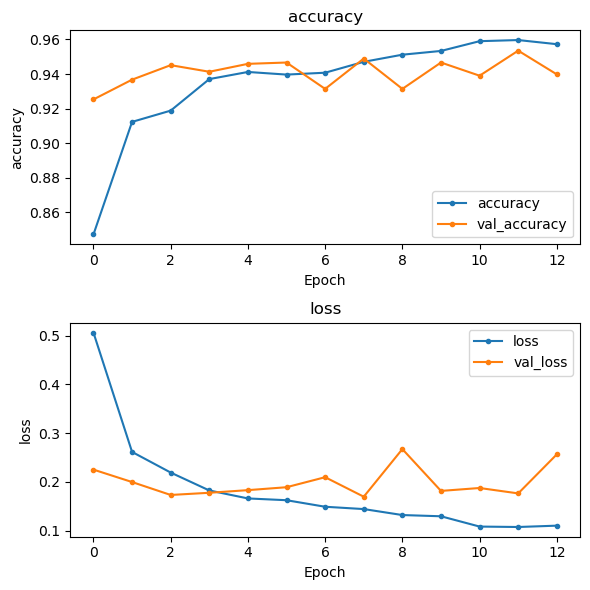


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1405
           1       0.94      0.99      0.97      1579
           2       0.98      0.95      0.97      1624

    accuracy                           0.97      4608
   macro avg       0.98      0.97      0.97      4608
weighted avg       0.97      0.97      0.97      4608



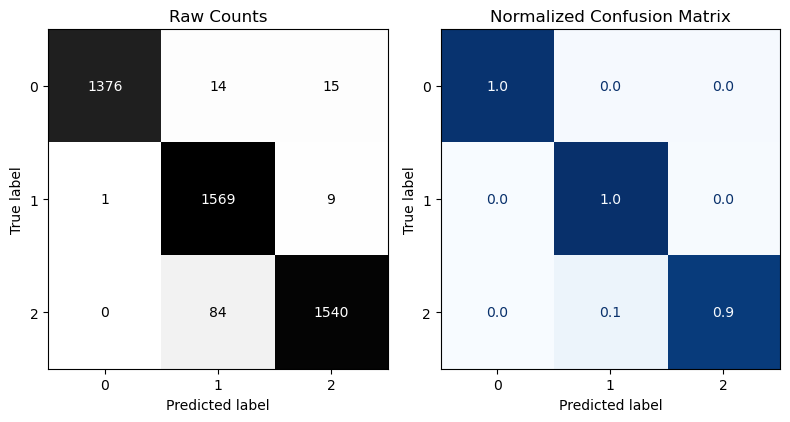


- Evaluating Training Data:
144/144 [==============================] - 71s 491ms/step - loss: 0.0609 - accuracy: 0.9733
{'loss': 0.06094471737742424, 'accuracy': 0.9733073115348816}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       194
           1       0.91      0.97      0.94       251
           2       0.96      0.95      0.95       252

    accuracy                           0.95       697
   macro avg       0.96      0.95      0.95       697
weighted avg       0.95      0.95      0.95       697



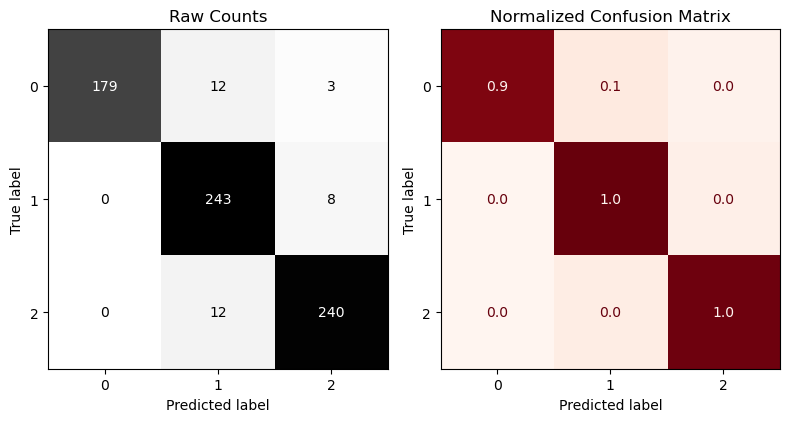


- Evaluating Test Data:
22/22 [==============================] - 11s 480ms/step - loss: 0.2008 - accuracy: 0.9498
{'loss': 0.20081570744514465, 'accuracy': 0.9497848153114319}


In [40]:
# Use evaluation function
evaluate_classification_network(
    enet_model, X_train=train_ds, X_test=test_ds,
    history=enet_history, figsize=(8, 8), 
    values_format=".1f");

**Evaluate EfficientNet Model**
-  The EfficientNet Model has performed extremely well.
-  Although it has an accuracy of 95%, it does have a few incorrect predictions.
- There are a handful of false positives, but these were reduced compared to the other models
- There are a handful of false negatives.

#### Choose the Best Model

-  Of the three models the best model is the 3rd model, the enet_model.  This model was able to classify with 95% accuracy the xrays.  There are a few false positive and false negatives.  These would need further evaluation, as having a false negative result would mean patients were not treated who neeeded to be.
-  I would put the EfficientNet Model into production with a little more tuning.

In [41]:
enet_model.save('Models/EfficientNet-Model')

INFO:tensorflow:Assets written to: Models/EfficientNet-Model\assets


INFO:tensorflow:Assets written to: Models/EfficientNet-Model\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.